In [1]:
import numpy as np
import qutip as qt
import math
from scipy.integrate import simps
from scipy.special import hermite
from scipy.interpolate import interp1d
import tensorflow as tf

In [2]:
d = 4
big_d = 40

In [3]:
init_state = qt.rand_dm_ginibre(d)  # initial state is d-dimensional
full_array = np.zeros((big_d, big_d), dtype=np.complex128)
full_array[:d, :d] = init_state.full()  # this transforms the initial d-dimensional state into D-dim
full_state = qt.Qobj(full_array)

In [4]:
traj_length = 20  # how many "snapshots" in time we take
nof_samples_distr = 1000  # how many points to sample from distribution
tlist = np.linspace(0, 2 * np.pi, traj_length)  # we're taking traj_length points from one period of motion - 2 pi
xmax = 5
x_list = np.linspace(-xmax, xmax, 200)  # setting up the x space for P(x) and for wigner

alpha = 5  # inverse quarticity
gamma = 0  # decoherence rate

# QUANTUM DEFINITIONS
a = qt.destroy(big_d)  # annihilation operator
x = a.dag() + a
p = 1j * (a.dag() - a)
H_quartic = p * p / 4 + (x / alpha) * (x / alpha) * (x / alpha) * (x / alpha)
H_harmonic = a.dag() * a
# # A list of collapse operators - later
c_ops = [np.sqrt(gamma) * x]  # decoherence

In [5]:
result = qt.mesolve(H_harmonic, full_state, tlist, c_ops=c_ops)

In [6]:
def Psi_Psi_product(xlist, dim):
    """
    This function calculates the product of the wave functions psi_m and psi_n for a given list of x.

    Parameters:
    xlist (ndarray): List of x values
    dim (int): Dimension of the product matrix

    Returns:
    product_matrix (ndarray): Matrix with [m,n] element as product psi_m * psi_n"""
    product_list = []

    exp_list = np.exp(-xlist ** 2 / 2.0)
    norm_list = [np.pi ** (-0.25) / math.sqrt(2.0 ** m * math.factorial(m)) for m in range(dim)]
    herm_list = [np.polyval(hermite(m), xlist) for m in range(dim)]

    for m in range(dim):
        psi_m = exp_list * norm_list[m] * herm_list[m]  # wave function psi_m of a harmonic oscillator
        for ni in range(dim):
            psi_n = exp_list * norm_list[ni] * herm_list[ni]  # wave function psi_n of a harmonic oscillator
            product_list.append(psi_m * psi_n)  # in general should be np.conjugate(psi_n)

    product_matrix = np.reshape(product_list,
                                (dim, dim, -1))  # reshape into matrix, such that [m,n] element is product psi_m*psi_n
    return product_matrix


psi_products = Psi_Psi_product(x_list, big_d)

In [7]:
def draw_from_prob(xlist, prob_list, m):
    """
        Draw `m` samples from a probability distribution defined by `xlist` and `prob_list`.

        Parameters
        ----------
        xlist : ndarray
            A 1D array of x values.
        prob_list : ndarray
            A 1D array of probability values corresponding to the `xlist`.
        m : int
            The number of samples to draw.

        Returns
        -------
        draw_samples : ndarray
            A 1D array of `m` samples drawn from the probability distribution.
        """

    norm_constant = simps(prob_list, xlist)  # normalization
    my_pdfs = prob_list / norm_constant  # generate PDF
    my_cdf = np.cumsum(my_pdfs)  # generate CDF
    my_cdf = my_cdf / my_cdf[-1]
    func_ppf = interp1d(my_cdf, xlist, fill_value='extrapolate')  # generate the inverse CDF
    draw_samples = func_ppf(np.random.uniform(size=m))  # generate M samples

    return draw_samples

In [8]:
rho_matrix = result.states[10].full()  # we're taking each state in snapshots of time

before_sum = rho_matrix[:, :, np.newaxis] * psi_products
first_sum = np.sum(before_sum.real, axis=0)
prob_list = np.sum(first_sum, axis=0)  # P(x) = sum ( rho * psi_products ) by definition
sample = draw_from_prob(x_list, prob_list, nof_samples_distr)  # drawing points from P(x)

In [9]:
before_sum1 = tf.math.multiply(rho_matrix[:, :, tf.newaxis], psi_products)
first_sum1 = tf.math.reduce_sum(tf.math.real(before_sum1), axis=0)
prob_list1 = tf.math.reduce_sum(first_sum1, axis=0)  # P(x) = sum ( rho * psi_products ) by definition
sample1 = draw_from_prob(x_list, prob_list1, nof_samples_distr)  # drawing points from P(x)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-26 12:01:04.114724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-26 12:01:04.115239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
norm_constant = simps(prob_list, x_list)  # normalization
my_pdfs = prob_list / norm_constant  # generate PDF
my_cdf = np.cumsum(my_pdfs)  # generate CDF
my_cdf = my_cdf / my_cdf[-1]
func_ppf = interp1d(my_cdf, x_list, fill_value='extrapolate')  # generate the inverse CDF
draw_samples = func_ppf(np.random.uniform(size=10000))  # generate M samples

norm_constant1 = simps(prob_list1, x_list)  # normalization
my_pdfs1 = prob_list1 / norm_constant1  # generate PDF
my_cdf1 = np.cumsum(my_pdfs1)  # generate CDF
my_cdf1 = my_cdf1 / my_cdf1[-1]
func_ppf1 = interp1d(my_cdf1, x_list, fill_value='extrapolate')  # generate the inverse CDF
draw_samples1 = func_ppf1(np.random.uniform(size=10000))  # generate M samples

(array([  3.,   0.,   0.,   1.,   3.,   6.,   8.,  13.,  14.,  16.,  33.,
         26.,  34.,  44.,  43.,  66.,  96.,  90., 110., 120., 133., 162.,
        155., 175., 153., 170., 174., 155., 147., 154., 136., 125., 119.,
        112., 107.,  88.,  73.,  97.,  80.,  75.,  87.,  67.,  82.,  93.,
         81., 112., 117., 119., 148., 167., 170., 197., 188., 204., 223.,
        181., 184., 168., 149., 146., 133., 100.,  97., 101., 118., 104.,
        110., 128., 147., 166., 177., 192., 218., 218., 231., 215., 170.,
        187., 148., 134., 127., 127.,  89.,  70.,  78.,  60.,  52.,  21.,
         27.,  11.,  12.,   7.,   6.,   7.,   6.,   1.,   1.,   0.,   3.,
          2.]),
 array([-3.65926137, -3.58525481, -3.51124826, -3.43724171, -3.36323516,
        -3.28922861, -3.21522206, -3.14121551, -3.06720895, -2.9932024 ,
        -2.91919585, -2.8451893 , -2.77118275, -2.6971762 , -2.62316965,
        -2.5491631 , -2.47515654, -2.40114999, -2.32714344, -2.25313689,
        -2.17913034, -2.10

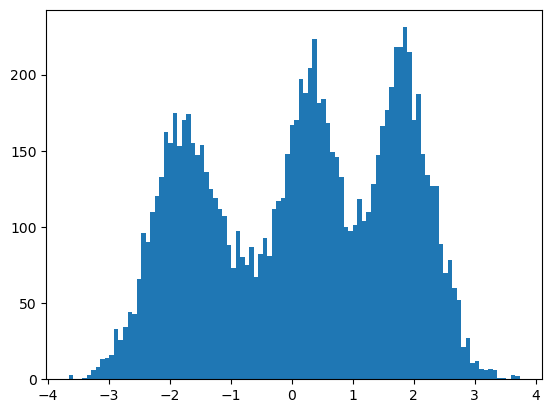

In [11]:
import matplotlib.pyplot as plt
plt.hist(draw_samples, bins=100)

(array([  1.,   0.,   0.,   3.,   3.,   3.,   5.,  12.,  11.,  16.,  16.,
         19.,  22.,  42.,  51.,  55.,  77.,  78., 106., 123., 148., 124.,
        161., 177., 161., 174., 158., 186., 168., 166., 154., 126., 124.,
        120., 106., 106.,  84.,  76.,  88.,  82.,  69.,  84.,  85.,  85.,
        111., 112., 141., 174., 177., 186., 206., 202., 239., 203., 177.,
        187., 162., 164., 120., 120., 111., 107., 103., 105., 139., 141.,
        176., 181., 204., 232., 220., 244., 228., 237., 177., 199., 162.,
        152., 108., 101.,  67.,  51.,  52.,  47.,  40.,  23.,  14.,  12.,
         11.,   5.,   5.,   3.,   2.,   3.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([-3.78248416, -3.70385048, -3.6252168 , -3.54658311, -3.46794943,
        -3.38931575, -3.31068206, -3.23204838, -3.1534147 , -3.07478102,
        -2.99614733, -2.91751365, -2.83887997, -2.76024628, -2.6816126 ,
        -2.60297892, -2.52434523, -2.44571155, -2.36707787, -2.28844418,
        -2.2098105 , -2.13

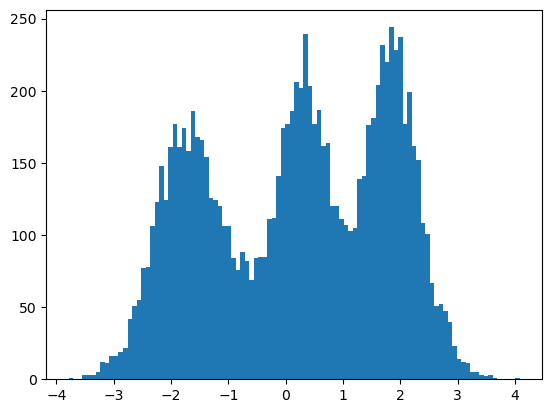

In [12]:
plt.hist(draw_samples1, bins=100)